# Deep Q-Learning
This tutorial is adapted from this [blog post](https://towardsdatascience.com/deep-q-learning-tutorial-mindqn-2a4c855abffc). We will be using Deep Q-Learning to train a neural network to solve the cart pole problem. We are given pole on a cart,

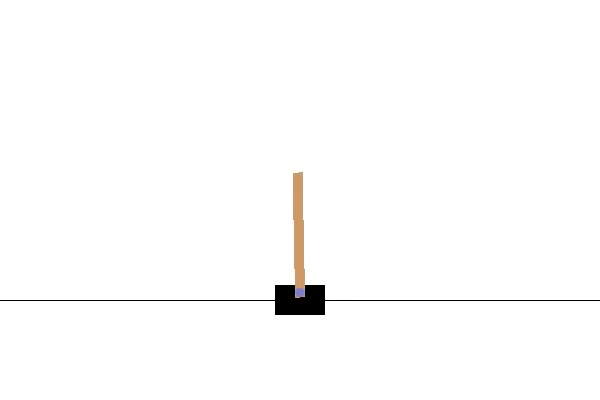

Our task is to move the cart such that the pole stays balanced. We can apply a force to the right or left. The pole is balanced if it is less than 15 degrees from the vertical and the cart's position is less than 2.4 units from the center. We end each "episode" of our simulation when the pole is no longer balanced. Let's formulate this problem as a Markov Decision Process $(S,A,P_a,R_a)$.
- Our state space $S$ consists of all possible combinations of these four values: the position of the cart, the velocity of the cart, the angle of the pole, and the rotation rate of the pole.
- Our action space $A$ consists of either applying a force of $+1$ or $-1$ to the cart.
- Our probability function $P_a$ is implicitly modeled by the episodic simulation that transitions to state $s'$ given state $s$ and action $a$.
- Our reward function $R_a$ gives a $+1$ reward if the pole is still upright for a transition between states $s$ and $s'$.

In [ ]:
# Necessary imports
import random
from collections import deque
import numpy as np
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# OpenAI's reinforcement learning environment
import gym

Let's seed our random number generators and create the environment.

In [ ]:
RANDOM_SEED = 42
tf.random.set_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
# Make the environment
env = gym.make('CartPole-v1')
env.seed(RANDOM_SEED)

[42]

## Creating the Neural Network
We are going to first list some hyperparameters we need for training.

In [ ]:
# Hyperparameters
train_episodes = 300
learning_rate = 1e-3
batch_size = 128
# Bellman equation weight
alpha = 0.7 
# Discount factor
gamma = 0.618
# Minimum and maximum sizes of replay buffer
REPLAY_BUFFER_MIN = 1000
REPLAY_BUFFER_MAX = 50000
# When to update main model
update = 4
# When to update target model
update_t = 100
# Epsilon-greedy parameters
epsilon = 1
max_epsilon = 1
min_epsilon = 0.01
epsilon_decay = 0.01

Now let's create a small neural network to predict the Q-values associated with our two actions.

In [ ]:
def get_model(state_shape, action_shape):
    initializer = tfk.initializers.HeUniform()
    return tfk.Sequential([
        tfkl.Dense(24, input_shape=state_shape, activation='relu', 
                   kernel_initializer=initializer),
        tfkl.Dense(12, activation='relu', kernel_initializer=initializer),
        tfkl.Dense(action_shape, kernel_initializer=initializer)
    ])

Now let's write a train method. Recall the Bellman equation to update our Q-values,

$$Q(s_t,a_t)\leftarrow Q(s_t,a_t)+\alpha\left(r_t+\gamma\cdot\max_a\,Q(s_{t+1},a)-Q(s_t,a_t)\right)$$

In [ ]:
def train(env, replay_buffer, model, target_model, done):
    # Ensure we have a buffer of minimum size
    if len(replay_buffer) < REPLAY_BUFFER_MIN:
        return 
    
    # Get `batch_size` samples from our buffer to train on
    # Replay buffer is (s, a, reward, s', done)
    samples = random.sample(replay_buffer, batch_size)
    states = np.array([elem[0] for elem in samples])
    qs = model.predict(states)
    new_states = np.array([elem[3] for elem in samples])
    new_qs = target_model.predict(new_states)

    X = []
    Y = []
    # Time to compute terms of the Bellman equation
    for i, (s, a, r, s_prime, done) in enumerate(samples):
        if not done:
            # Maximum quality from new state and reward
            max_q = r + gamma * np.max(new_qs[i])
        else:
            # No future states
            max_q = r
        qs_ = qs[i]
        # Update Q-values
        qs_[a] = (1 - alpha) * qs_[a] + alpha * max_q

        X.append(s)
        Y.append(qs_)

    # Train to predict Q-values; shuffle so as not to impose bad priors
    model.fit(np.array(X), np.array(Y), batch_size=batch_size, verbose=0, shuffle=True)

### Huber Loss
We are going to use Huber loss, which is a mix between MSE and MAE. It is robust to outliers like MAE but is lenient on predicted values close to the target like MSE. The equation is below,

$$
L_\delta(a)=\begin{cases}
\frac{1}{2}a^2,\qquad\qquad\qquad\,\text{for } |a|\leq\delta \\
\delta\cdot\left(|a|-\frac{1}{2}\delta\right),\qquad\text{otherwise}
\end{cases}
$$

We can see for small values, the Huber loss is equivalent to MSE while it is equivalent to MAE for larger values,

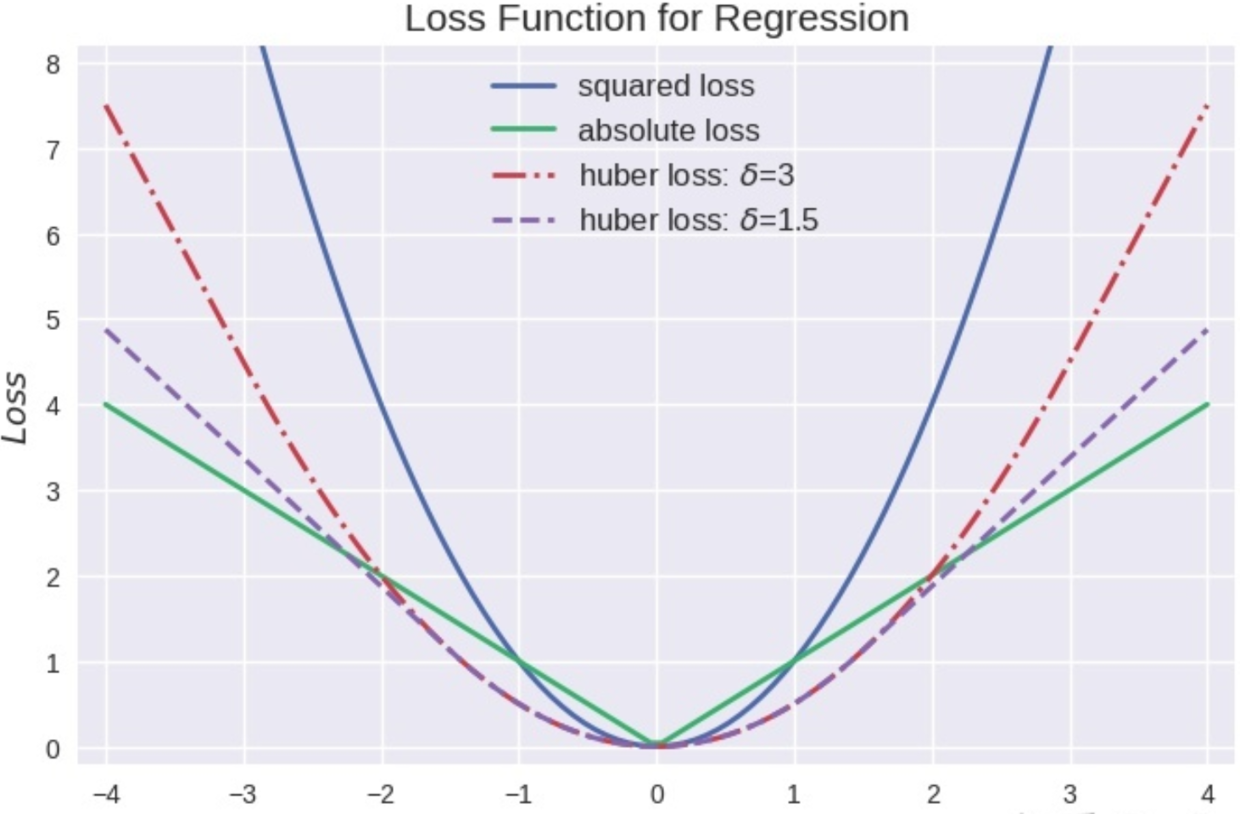

### Nadam

We are going to use the Nadam optimizer, which is similar to the Adam optimizer, but uses Nesterov momentum which has nice theoretical convergence properties. Check out this [blog post](https://dominikschmidt.xyz/nesterov-momentum/) for more information. Given our loss function $J(\theta)$, timestep $t$, learning rate $\eta$, momentum-decay parameter $\psi$, and optional weight-decay parameter $\lambda$, the equations are,

$$g_t\leftarrow\nabla_\theta J_t(\theta_{t-1})+\lambda\theta_{t-1}$$
$$\mu_t\leftarrow\beta_1\left(1-\frac{1}{2}0.96^{t\psi}\right)$$
$$\mu_{t+1}\leftarrow\beta_1\left(1-\frac{1}{2}0.96^{(t+1)\psi}\right)$$
$$m_t\leftarrow\beta_1m_{t-1}+(1-\beta_1)g_t$$
$$s_t\leftarrow\beta_2s_{t-1}+(1-\beta_2)g_t⊙g_t$$
$$\hat{m}_t\leftarrow\frac{\mu_{t+1}m_t}{1-\prod_{i=1}^{t+1}\mu_i}+\frac{(1-\mu_t)g_t}{1-\prod_{i=1}^t\mu_i}$$
$$\hat{s}_t\leftarrow\frac{s_t}{1-\beta_2^t}$$
$$\theta_t\leftarrow\theta_{t-1}-\eta\,\hat{m}_t\oslash\sqrt{\hat{s}_t+\epsilon}$$

Where $⊙$ denotes element-wise multiplication, $⊘$ denotes element-wise division (Hadamard), and $\epsilon$ is a small constant added for numerical stability.

### Models
In Deep Q-Learning, we generally create a main model to train on, then a target model we update periodically with the same weights as the main model. This is for stability. I am also going to create a third model to store the model that maximizes reward.

In [ ]:
model = get_model((4,), 2)
target_model = get_model((4,), 2)
best_model = get_model((4,), 2)

In [ ]:
loss = tfk.losses.Huber()
optimizer = tfk.optimizers.Nadam(learning_rate)
model.compile(loss=loss, optimizer=optimizer)
target_model.compile(loss=loss, optimizer=optimizer)
best_model.compile(loss=loss, optimizer=optimizer)

In [ ]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_37 (Dense)            (None, 24)                120       
                                                                 
 dense_38 (Dense)            (None, 12)                300       
                                                                 
 dense_39 (Dense)            (None, 2)                 26        
                                                                 
Total params: 446
Trainable params: 446
Non-trainable params: 0
_________________________________________________________________


## Training the Neural Network
To begin our training process, we will use the epsilon-greedy algorithm to randomly sample our problem space. With probability $\epsilon\in[\epsilon_\text{min},\epsilon_\text{max}]$, we take a random action to explore our space. We then update $\epsilon$ as,

$$\epsilon=\epsilon_\text{min}+(\epsilon_\text{max}-\epsilon_\text{min})e^{-dt}$$

Here, $d$ is a decay factor and $t$ is the current episode we are on.

In [ ]:
replay_buffer = deque(maxlen=REPLAY_BUFFER_MAX)
# Set all our weights to be the same
target_model.set_weights(model.get_weights())
best_model.set_weights(model.get_weights())

best_reward = 0
update_target = 0

for episode in range(train_episodes):
    total_reward = 0
    # Get state
    s = env.reset()
    done = False
    while not done:
        update_target += 1

        if np.random.rand() <= epsilon:
            # Randomly sample action based on epsilon-greedy algorithm
            action = env.action_space.sample()
        else:
            # Get action from model
            predicted = model.predict(np.expand_dims(s, axis=0)).flatten()
            action = np.argmax(predicted)
        s_prime, reward, done, _ = env.step(action)
        replay_buffer.append([s, action, reward, s_prime, done])

        # Update model
        if update_target % update == 0 or done:
            train(env, replay_buffer, model, target_model, done)
        
        s = s_prime
        total_reward += reward

        if done:
            print(f'Episode:\t{episode}\nTotal reward:\t{total_reward}\n')

            if update_target >= update_t:
                print('Updating target...')
                target_model.set_weights(model.get_weights())
                update_target = 0
            if total_reward > best_reward:
                print('Updating best...')
                best_reward = total_reward
                best_model.set_weights(model.get_weights())

            break

    epsilon = min_epsilon + (max_epsilon - min_epsilon) * \
        np.exp(-epsilon_decay * episode)

Episode:	0
Total reward:	19.0

Updating best...
Episode:	1
Total reward:	20.0

Updating best...
Episode:	2
Total reward:	17.0

Episode:	3
Total reward:	33.0

Updating best...
Episode:	4
Total reward:	29.0

Updating target...
Episode:	5
Total reward:	17.0

Episode:	6
Total reward:	23.0

Episode:	7
Total reward:	25.0

Episode:	8
Total reward:	11.0

Episode:	9
Total reward:	17.0

Episode:	10
Total reward:	17.0

Updating target...
Episode:	11
Total reward:	33.0

Episode:	12
Total reward:	14.0

Episode:	13
Total reward:	17.0

Episode:	14
Total reward:	13.0

Episode:	15
Total reward:	12.0

Episode:	16
Total reward:	14.0

Updating target...
Episode:	17
Total reward:	12.0

Episode:	18
Total reward:	34.0

Updating best...
Episode:	19
Total reward:	11.0

Episode:	20
Total reward:	12.0

Episode:	21
Total reward:	24.0

Episode:	22
Total reward:	15.0

Updating target...
Episode:	23
Total reward:	15.0

Episode:	24
Total reward:	11.0

Episode:	25
Total reward:	19.0

Episode:	26
Total reward:	14.0

Ep

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
best_model.save('/content/drive/MyDrive/best_cartpole')
best_model.save('best_cartpole')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/best_cartpole/assets
INFO:tensorflow:Assets written to: best_cartpole/assets


In [ ]:
import shutil 
shutil.make_archive('best_cartpole', 'zip', 'best_cartpole')

'/content/best_cartpole.zip'

Note that we can use `env.render()` to draw the scenes of our game if we wanted to visualize how our model did (by querying it for actions as we stepped through).